In [20]:
 ################## Imports ################### 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import seaborn as sns
from ydata_profiling import ProfileReport

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import joblib
from joblib import dump, load

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns



import mlflow
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000

In [21]:
# Cargamos el dataset
df = pd.read_pickle('../data/dataset_03_07.pickle')
df.drop(columns = ['modelo_std'], inplace=True)
df = df.reset_index(drop=True)

categorical_columns = ['marca', 'Tipo', 'Transmision']
df_dummies = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [22]:
# Separar las características y el target
X = df_dummies.drop(columns='precio')

y = df_dummies['precio']
#Separamos en train y test:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(x_train)

#Escalamos la y para tratar de opacar el efecto de los precios de autos caros
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(np.array(y_train).reshape(-1,1))
#Escalamos las y_test
y_test_scaled = scaler_y.transform(np.array(y_test).reshape(-1,1))


In [23]:
X_train_scaled = pd.DataFrame(scaler_x.transform(x_train), columns=x_train.columns)
X_test_scaled = pd.DataFrame(scaler_x.transform(x_test), columns=x_test.columns)

# Crear pools de datos de CatBoost
train_pool = Pool(X_train_scaled, y_train_scaled)
test_pool = Pool(X_test_scaled, y_test_scaled)

# Definir el modelo base
model = CatBoostRegressor(
    random_seed=42,
    verbose=True
)

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8],
    'l2_leaf_reg': [3, 5],
    'border_count': [32, 64]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1
)

# Ajustar GridSearchCV
grid_search.fit(X_train_scaled, y_train_scaled)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Mejores parámetros:", best_params)


Fitting 4 folds for each of 48 candidates, totalling 192 fits
0:	learn: 0.1843530	total: 2.18ms	remaining: 3.27s
1:	learn: 0.1832730	total: 3.13ms	remaining: 2.35s
2:	learn: 0.1821718	total: 3.99ms	remaining: 1.99s
3:	learn: 0.1810646	total: 5.7ms	remaining: 2.13s
4:	learn: 0.1799683	total: 7.08ms	remaining: 2.12s
5:	learn: 0.1790246	total: 8.82ms	remaining: 2.2s
6:	learn: 0.1779486	total: 10.9ms	remaining: 2.32s
7:	learn: 0.1768662	total: 12.7ms	remaining: 2.37s
8:	learn: 0.1757948	total: 14.4ms	remaining: 2.38s
9:	learn: 0.1748534	total: 15.5ms	remaining: 2.31s
10:	learn: 0.1738098	total: 16.4ms	remaining: 2.21s
11:	learn: 0.1728145	total: 17.9ms	remaining: 2.22s
12:	learn: 0.1718083	total: 19.5ms	remaining: 2.23s
13:	learn: 0.1708813	total: 21.1ms	remaining: 2.24s
14:	learn: 0.1698396	total: 23.8ms	remaining: 2.35s
15:	learn: 0.1689356	total: 25.4ms	remaining: 2.36s
16:	learn: 0.1679605	total: 27ms	remaining: 2.35s
17:	learn: 0.1670397	total: 28.5ms	remaining: 2.35s
18:	learn: 0.166

In [24]:
# Evaluar el mejor modelo en el conjunto de prueba
y_pred_cat = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, y_pred_cat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred_cat)
mae = mean_absolute_error(y_test_scaled, y_pred_cat)

print(f"RMSE: {rmse}")  #0.05428
print(f"R2 Score: {r2}") #0.8909
print(f"MAE Score: {mae}") #0.036


RMSE: 0.054285341222703704
R2 Score: 0.8909949347923254
MAE Score: 0.03677142958254725


In [25]:
# Pasamos a la escala Original:
y_pred_cat = best_model.predict(X_test_scaled)

y_pred_cat_original = scaler_y.inverse_transform(y_pred_cat.reshape(147,1))

mse = mean_squared_error(y_test, y_pred_cat_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_cat_original)
mae = mean_absolute_error(y_test, y_pred_cat_original)




RMSE: 4494.826253239866
R2 Score: 0.8909949347923254
MAE Score: 3044.6743694349125


In [26]:
best_model.save_model('catboost_model.cbm')

columnas_modelo = best_model.feature_names_
print(columnas_modelo)

['Motor', 'Ano', 'marca_BMW', 'marca_Baic', 'marca_Borgward', 'marca_Changan', 'marca_Chery', 'marca_Chevrolet', 'marca_DFM', 'marca_Daihatsu', 'marca_Dodge', 'marca_Fiat', 'marca_Ford', 'marca_Foton', 'marca_GAC', 'marca_Geely', 'marca_Great Wall', 'marca_Haval', 'marca_Honda', 'marca_Hyundai', 'marca_JAC', 'marca_Jeep', 'marca_KIA', 'marca_Lada', 'marca_Land Rover', 'marca_Lexus', 'marca_Maxus', 'marca_Mazda', 'marca_Mercedes Benz', 'marca_Mitsubishi', 'marca_Nissan', 'marca_Peugeot', 'marca_Porche', 'marca_Renault', 'marca_Ssangyong', 'marca_Subaru', 'marca_Suzuki', 'marca_Tata', 'marca_Toyota', 'marca_UAZ', 'marca_Volkswagen', 'marca_ZNA', 'marca_Zotye', 'marca_citroen', 'Tipo_CityCar', 'Tipo_Deportivo', 'Tipo_Furgon', 'Tipo_Hatchback', 'Tipo_SUV', 'Tipo_sedan', 'Transmision_automatico', 'Transmision_manual']


In [27]:
#Guardamos el catboosting model:
joblib.dump(best_model, 'catboosting_model_car_model_17_08.pickle')


['catboosting_model_car_model_17_08.pickle']

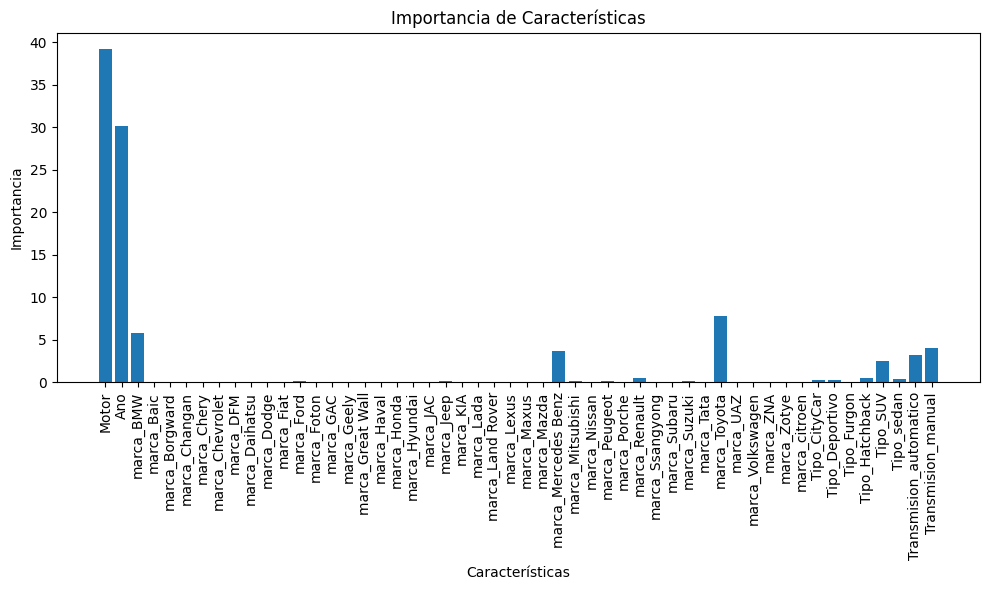

In [28]:
# Graficar la importancia de las características

feature_importance = best_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Importancia de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
mlflow.set_tracking_uri('http://localhost:5001')

experiment_name = "exp_AutosUsados"

if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(name=experiment_name) 

experiment = mlflow.get_experiment_by_name(experiment_name)

mlflow.sklearn.log_model(best_model, 'AutosUsados_catbooster')